In [377]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [378]:
# --- Optimization implementation 

data = pd.read_excel('Data-20251101/epfl_gym_wait_times_study.xlsx')
students_emp = data['Students_Present'].values

# -------- Parameters & baselines

# # Baseline 
n0 = 57      # number of equipments     
N_MIN, N_MAX = 1, 260      # feasibility students interval
N_EQUIP_MIN, N_EQUIP_MAX = 50, 64   
H_MIN, H_MAX = 8, 16       
UTIL_THRESHOLD = 0.80
UTIL_SCALE = 0.2
u_1, u_2, u_3 = 0.4, 0.35, 0.25 # weights for Category 1
benefit_per_student_visit = 1.3  # CHF
max_waiting_time = 8.0 # minutes
gen_target = 0.5
gender_gap = gen_target - 0.45
disab_target = 0.0375
disab_gap = disab_target - 0.025
beta_gend = 1.25
beta_disab = 1.55

# ----- For Sensitivity

# Lenient Extreme
# n0 = 57      # number of equipments     
# N_MIN, N_MAX = 1, 260      # feasibility students interval
# N_EQUIP_MIN, N_EQUIP_MAX = 50, 64   
# H_MIN, H_MAX = 8, 16       
# UTIL_THRESHOLD = 0.85
# UTIL_SCALE = 0.2
# u_1, u_2, u_3 = 0.5, 0.30, 0.20 # weights for Category 1
# benefit_per_student_visit = 1.5  # CHF
# max_waiting_time = 9.0 # minutes
# gen_target = 0.45
# gender_gap = gen_target - 0.45
# disab_target = 0.035
# disab_gap = disab_target - 0.025
# beta_gend = 1.0
# beta_disab = 1.3

# Strict Extreme 
# n0 = 57      # number of equipments     
# N_MIN, N_MAX = 1, 260      # feasibility students interval
# N_EQUIP_MIN, N_EQUIP_MAX = 50, 64   
# H_MIN, H_MAX = 8, 16       
# UTIL_THRESHOLD = 0.75
# UTIL_SCALE = 0.2
# u_1, u_2, u_3 = 0.3, 0.40, 0.30 # weights for Category 1
# benefit_per_student_visit = 1.0  # CHF
# max_waiting_time = 7.0 # minutes
# gen_target = 0.5
# gender_gap = gen_target - 0.45
# disab_target = 0.04
# disab_gap = disab_target - 0.025
# beta_gend = 1.4
# beta_disab = 1.6

# ------ Help functions
def scaled_students_sample(N, students):
    """
    Scale the empirical distribution 'students' so that its mean becomes N.
    """
    mu_emp = students.mean()
    k = N / mu_emp
    x = students * k          # scaled distribution (floats)

    return x

def W_inv(w = max_waiting_time):
    """
    Invert waiting time proxy W(N, n).
    Given W_target and n, return the larger root N solving W(N, n) = W_target.
    """
    A = 0.000815465
    B = -0.016510
    C = 1.458321 - w

    disc = B**2 - 4 * A * C
    if disc < 0:
        raise ValueError(f"No real solution for N: discriminant < 0 (disc={disc}).")

    sqrt_disc = np.sqrt(disc)
    N1 = (-B - sqrt_disc) / (2 * A)
    N2 = (-B + sqrt_disc) / (2 * A)

    return round(max(N1, N2))

def W(N, n):
    """Waiting time proxy W(N,n)."""
    return (1.458321 - 0.016510 * N + 0.000815465 * (N ** 2)) * n0 / n

def U_of_W(N, n):
    """Utility of waiting time U(W(N,n))."""
    w = W(N, n)
    return 5.913e-4 * (w ** 2) + 2.511e-2 * w + 0.370

def A(N, n, H):
    """Access (Category 1, component A)."""
    if N <= 0:
        return 0.0  # avoid division by zero; N=0 not meaningful in practice
    return H * n / (N * 1.233)

def B(N, n):
    """Waiting (Category 1, component B)."""
    return (W(N, n) / 8.0) ** 2

def C(N, students):
    x = scaled_students_sample(N, students)
    util = x / CAPACITY
    overshoot = np.maximum((util - UTIL_THRESHOLD) / UTIL_SCALE, 0.0) #already in [0,1]
    return np.mean(overshoot ** 2)   

def E_raw(N, H):
    """Category 2 raw equity term (before weights and normalization)."""
    return (
        benefit_per_student_visit * 0.0233 * H * N
        - beta_gend * (gender_gap * N) ** 2
        - beta_disab * (disab_gap * N) ** 2
    )

def M_raw(N, n, H, students):
    x = scaled_students_sample(N, students)
    U_vals = np.array([U_of_W(xi, n) for xi in x]) 
    U_star = 5.913e-4 * (max_waiting_time ** 2) + 2.511e-2 * max_waiting_time + 0.370
    hinge_vals = np.maximum(U_vals - U_star, 0.0) ** 2

    U_mean = U_vals.mean()
    hinge_exp = hinge_vals.mean()

    return H * n * (0.113 * U_mean + 3.85 * hinge_exp)

def C_hat_annual(N, n, H, students):
    """Annual maintenance cost in the budget constraint."""
    return M_raw(N, n, H, students) * 48.0 * 7.0 

def is_feasible(N, n, H, students):
    """Check linear + cost constraints."""
    if not (N_MIN <= N <= N_MAX):
        return False
    if not (N_EQUIP_MIN <= n <= N_EQUIP_MAX):
        return False
    if not (H_MIN <= H <= H_MAX):
        return False

    if n == 0:
        return False  
    
    purchase_cost = max(7520/10 * (n-n0),0) # 7520 replacement cost, 20 average equipment lifetime

    budget_lhs = 1.38 * N * H * 48 * 7 + 614.035 * n + purchase_cost + C_hat_annual(N, n, H, students)
    
    return budget_lhs <= 484_000.0

CAPACITY = round(W_inv(max_waiting_time) / UTIL_THRESHOLD)
print(f"Computed capacity: {CAPACITY}")

Computed capacity: 125


In [379]:

# ------ Baseline normalizations 

def S_raw(N, n, H, students):
    """Category 1 raw score with normalized A,B,C."""
    A_tilde = (A(N, n, H) - A_min) / A_range
    B_tilde = (B(N, n) - B_min) / B_range
    C_tilde = C(N, students)
    return u_1 * A_tilde - u_2 * B_tilde - u_3 * C_tilde



# ---- INNER min–max normalization for A and B 
A_min, A_max = np.inf, -np.inf
B_min, B_max = np.inf, -np.inf

for H in range(H_MIN, H_MAX + 1):
    for n in range(N_EQUIP_MIN, N_EQUIP_MAX + 1):
        for N in range(N_MIN, N_MAX + 1):
            if not is_feasible(N, n, H, students_emp):
                continue
            a_val = A(N, n, H)
            b_val = B(N, n)
            A_min, A_max = min(A_min, a_val), max(A_max, a_val)
            B_min, B_max = min(B_min, b_val), max(B_max, b_val)

A_range = A_max - A_min
B_range = B_max - B_min
if A_range == 0 or B_range == 0:
    raise ValueError("A_range or B_range is zero – check A,B or feasible set.")

In [380]:
w_1 = 0.35
w_2 = 0.50
w_3 = 0.15

# ---- Objective function

S_min, S_max = np.inf, -np.inf
E_min, E_max = np.inf, -np.inf
M_min, M_max = np.inf, -np.inf

for H in range(H_MIN, H_MAX + 1):
    for n in range(N_EQUIP_MIN, N_EQUIP_MAX + 1):
        for N in range(N_MIN, N_MAX + 1):
            if not is_feasible(N, n, H, students_emp):
                continue
            S_val = S_raw(N, n, H, students_emp)    
            E_val = E_raw(N, H)
            M_val = M_raw(N, n, H, students_emp)

            S_min, S_max = min(S_min, S_val), max(S_max, S_val)
            E_min, E_max = min(E_min, E_val), max(E_max, E_val)
            M_min, M_max = min(M_min, M_val), max(M_max, M_val)

S_range = S_max - S_min
E_range = E_max - E_min
M_range = M_max - M_min
if S_range == 0:
    raise ValueError("S_range is zero – check the definition of S_raw or the feasible set.")
if E_range == 0:
    raise ValueError("E_range is zero – check the definition of E_raw or the feasible set.")
if M_range == 0:
    raise ValueError("M_range is zero – check the definition of M_raw or the feasible set.")


def objective(N, n, H, students):
    # ----- Category 1: inner normalization of A,B, then outer min–max 
    S_tilde = (S_raw(N, n, H, students) - S_min) / S_range   
    cat1 = w_1 * S_tilde

    # ----- Category 2 and 3 normalization
    cat2 = w_2 * (E_raw(N, H) - E_min) / E_range
    cat3 = w_3 * (M_raw(N, n, H, students) - M_min) / M_range

    return cat1 + cat2 - cat3

In [381]:

# ---- Brute-force search over integer ranges


best_val = -np.inf
best_sol = None

for H in range(H_MIN, H_MAX + 1):        # H_oper ∈ {8,...,16}
    for n in range(N_EQUIP_MIN, N_EQUIP_MAX + 1):    # n ∈ {50,...,64} 
        for N in range(N_MIN, N_MAX + 1):  # N ∈ {1,...,260}
            if not is_feasible(N, n, H, students_emp):
                continue

            val = objective(N, n, H, students_emp)
            if val > best_val:
                best_val = val
                best_sol = (N, n, H)

print("Best solution (N, n, H_oper):", best_sol)
print("Best objective value:        ", best_val)

# Components at the optimum:
if best_sol is not None:
    N_opt, n_opt, H_opt = best_sol
    A_tilde_opt = (A(N_opt, n_opt, H_opt) - A_min) / A_range
    B_tilde_opt = (B(N_opt, n_opt) - B_min) / B_range
    C_tilde_opt = C(N_opt, students_emp)
    cat1_opt = w_1 * (S_raw(N_opt, n_opt, H_opt, students_emp) - S_min) / S_range
    cat2_opt = w_2 * (E_raw(N_opt, H_opt) - E_min) / E_range
    cat3_opt = w_3 * (M_raw(N_opt, n_opt, H_opt, students_emp) - M_min) / M_range

    print("Category 1 contribution:", cat1_opt)
    print("Category 2 contribution:", cat2_opt)
    print("Category 3 contribution:", -cat3_opt)
    print("Maintenance expenditure:", C_hat_annual(N_opt, n_opt, H_opt, students_emp))
    print("Budget left:", 484_000.0 - (1.38 * N_opt * H_opt * 48 * 7 + 614.035 * n_opt + C_hat_annual(N_opt, n_opt, H_opt, students_emp) + max(7520/15 * (n_opt - n0), 0)))
    # print("Access (A_tilde):", A_tilde_opt, 
    #       "Waiting (B_tilde):", B_tilde_opt, 
    #       "Crowding (C_tilde):", C_tilde_opt)
    print("Objective value at the optimum (for the sensitivity analysis)", objective(58, 58, 13, students_emp))
    print("Maximum number of students allowed:", max(scaled_students_sample(N_opt, students_emp)))

Best solution (N, n, H_oper): (58, 58, 16)
Best objective value:         0.7000758959813779
Category 1 contribution: 0.2209092698435165
Category 2 contribution: 0.5
Category 3 contribution: -0.02083337386213854
Maintenance expenditure: 17052.989206022277
Budget left: 536.6074606444454
Objective value at the optimum (for the sensitivity analysis) 0.607033694814112
Maximum number of students allowed: 123.25830296720457


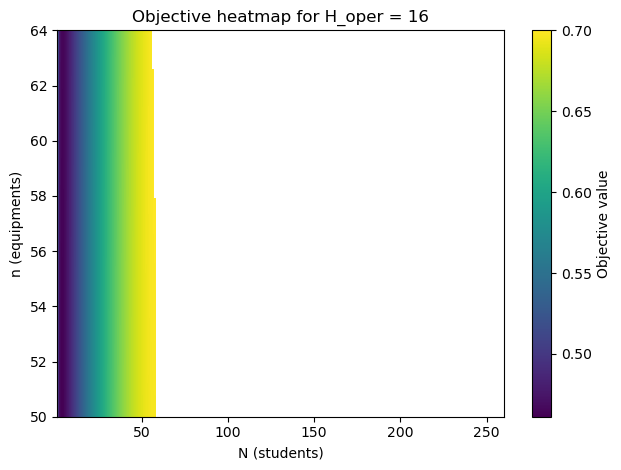

In [382]:
H_fix = 16
N_vals = range(N_MIN, N_MAX + 1)
n_vals = range(N_EQUIP_MIN, N_EQUIP_MAX + 1)

Z = np.full((len(n_vals), len(N_vals)), np.nan)

for i, n in enumerate(n_vals):
    for j, N in enumerate(N_vals):
        if not is_feasible(N, n, H_fix, students_emp):
            continue
        Z[i, j] = objective(N, n, H_fix, students_emp)

plt.figure()
plt.imshow(
    Z, origin='lower',
    extent=[min(N_vals), max(N_vals), min(n_vals), max(n_vals)],
    aspect='auto'
)
plt.colorbar(label="Objective value")
plt.xlabel("N (students)")
plt.ylabel("n (equipments)")
plt.title(f"Objective heatmap for H_oper = {H_fix}")
plt.tight_layout()
plt.show()

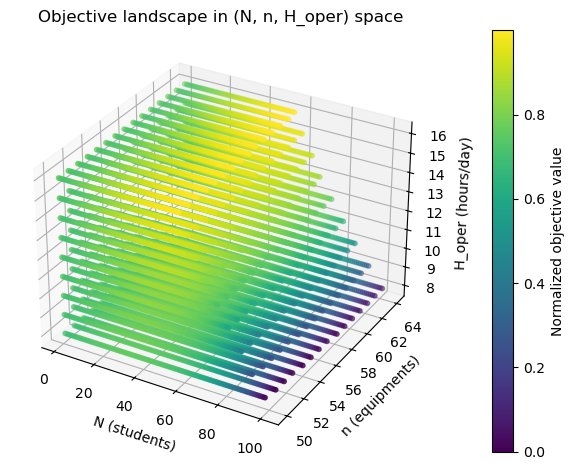

In [383]:
N_points = []
n_points = []
H_points = []
obj_points = []

for H in range(H_MIN, H_MAX + 1):
    for n in range(N_EQUIP_MIN, N_EQUIP_MAX + 1):
        for N in range(N_MIN, N_MAX + 1):
            if not is_feasible(N, n, H, students_emp):
                continue
            N_points.append(N)
            n_points.append(n)
            H_points.append(H)
            obj_points.append(objective(N, n, H, students_emp))

N_points = np.array(N_points)
n_points = np.array(n_points)
H_points = np.array(H_points)
obj_points = np.array(obj_points)

obj_min, obj_max = obj_points.min(), obj_points.max()
colors = (obj_points - obj_min) / (obj_max - obj_min + 1e-9)


# --- 3D scatter plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    N_points, n_points, H_points,
    c=colors, cmap='viridis', s=10
)

ax.set_xlabel("N (students)")
ax.set_ylabel("n (equipments)")
ax.set_zlabel("H_oper (hours/day)")
ax.set_title("Objective landscape in (N, n, H_oper) space")

cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Normalized objective value")

plt.tight_layout()
plt.show()